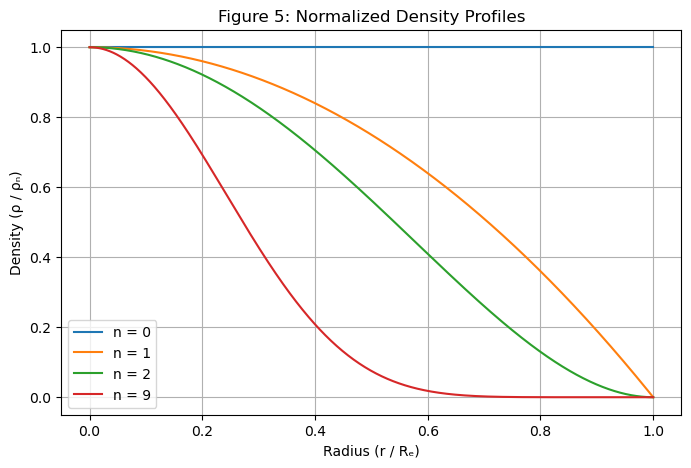

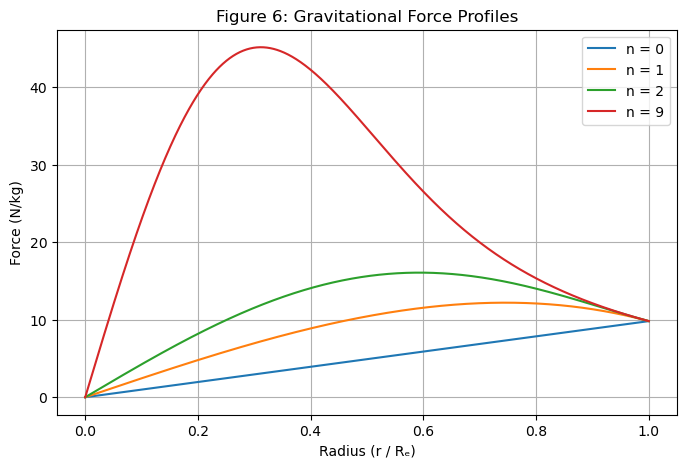

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Constants
R_earth = 6.371e6  # m
M_earth = 5.972e24  # kg
G = 6.67430e-11  # m^3 kg^-1 s^-2

# Step 1: Normalized density profiles
n_vals = [0, 1, 2, 9]
r = np.linspace(0, R_earth, 1000)

def density_profile(r, n):
    """Normalized density profile with ρ_n = 1"""
    return (1 - (r/R_earth)**2)**n

plt.figure(figsize=(8, 5))
for n in n_vals:
    plt.plot(r/R_earth, density_profile(r, n), label=f'n = {n}')
plt.title("Figure 5: Normalized Density Profiles")
plt.xlabel("Radius (r / Rₑ)")
plt.ylabel("Density (ρ / ρₙ)")
plt.legend()
plt.grid(True)
plt.show()

def integrand(r, n):
    return (1 - (r/R_earth)**2)**n * r**2

# Compute normalization constants
rho_n_dict = {}
for n in n_vals:
    integral, _ = quad(integrand, 0, R_earth, args=(n,))
    rho_n = M_earth / (4 * np.pi * integral)
    rho_n_dict[n] = rho_n

# Compute force profile
def enclosed_mass(r_val, n, rho_n):
    integrand = lambda r: rho_n * (1 - (r/R_earth)**2)**n * r**2
    mass, _ = quad(integrand, 0, r_val)
    return 4 * np.pi * mass

def gravitational_force(r_val, n):
    if r_val == 0:
        return 0
    M_enc = enclosed_mass(r_val, n, rho_n_dict[n])
    return G * M_enc / r_val**2

# Plot force profiles
plt.figure(figsize=(8, 5))
for n in n_vals:
    F = [gravitational_force(ri, n) for ri in r]
    plt.plot(r/R_earth, F, label=f'n = {n}')
plt.title("Figure 6: Gravitational Force Profiles")
plt.xlabel("Radius (r / Rₑ)")
plt.ylabel("Force (N/kg)")
plt.legend()
plt.grid(True)
plt.show()


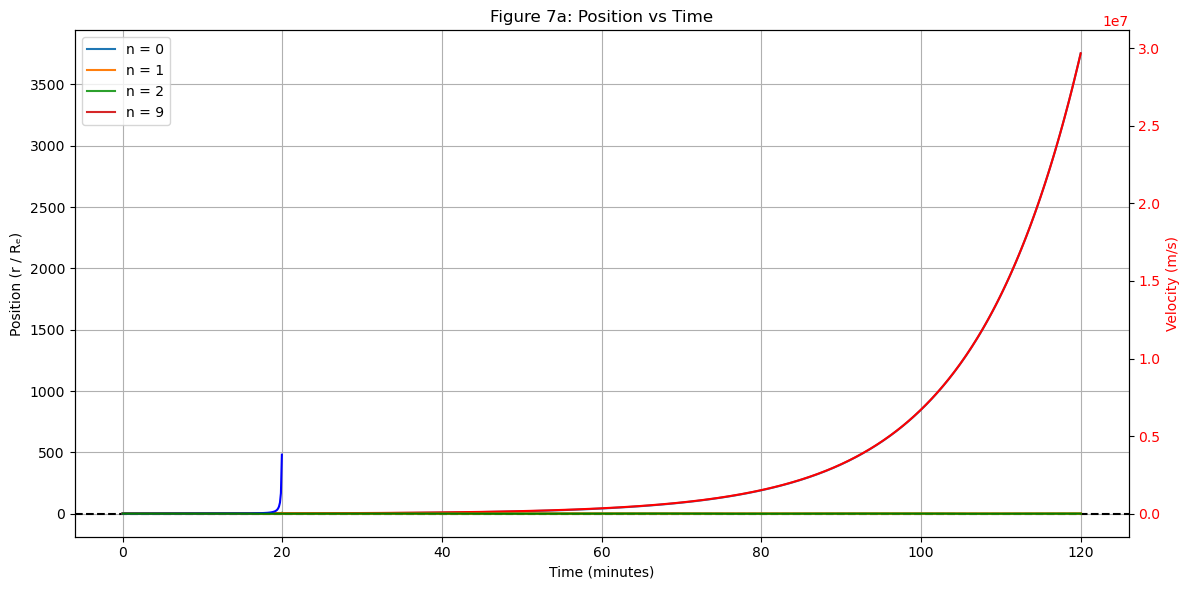

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.integrate import quad

# Constants
G = 6.6743e-11
Rad = 6378.1e3
M_earth = 5.972e24

# Function for the force at a given radius
def force(r, n, density):
    def mass_enclosed(r_val):
        def integrand(r2):
            return ((1 - (r2**2 / Rad**2))**n) * r2**2
        result, _ = quad(integrand, 0, r_val)
        return 4 * np.pi * density * result

    if r == 0:
        return 0  # Avoid divide-by-zero at the center
    m_enclosed = mass_enclosed(r)
    return G * m_enclosed / r**2

# Derivatives of position and velocity
def derivatives(t, s, n, density):
    r, v = s
    dydt = v
    dvdt = force(r, n, density) / 1  # Assuming object mass = 1 kg
    return [dydt, dvdt]

# Timespan
t0, tf = 0, 2 * 60 * 60  # Simulate for 2 hours
t_eval = np.linspace(t0, tf, 1000)

# Initial conditions: Starting from Earth's surface with zero velocity
y0 = [Rad, 0]

# Stopping condition: Stop when the object reaches the center (r = 0)
def stopping(t, s):
    return s[0]  # We want to stop when r reaches 0

# Required for `solve_ivp` to stop when the event is triggered
stopping.terminal = True  # This ensures the solver stops when the event is triggered
stopping.direction = -1   # Specifies the direction: we stop when the position is decreasing and reaches zero

# Wrapping the stopping function to handle the error with extra arguments
def stopping_wrapper(t, s, *args):
    return stopping(t, s)

# Calculate density constants for each n value
def compute_density_constant(n):
    # Compute the density constant ρn for each n value to normalize the mass correctly
    def integrand(r):
        return ((1 - r**2 / Rad**2)**n) * r**2
    
    result, _ = quad(integrand, 0, Rad)
    return M_earth / (4 * np.pi * result)

rho0 = compute_density_constant(0)
rho1 = compute_density_constant(1)
rho2 = compute_density_constant(2)
rho9 = compute_density_constant(9)

# Solve for different n values
sol0 = solve_ivp(derivatives, t_span=(t0, tf), y0=y0, t_eval=t_eval, args=(0, rho0), events=stopping_wrapper)
sol1 = solve_ivp(derivatives, t_span=(t0, tf), y0=y0, t_eval=t_eval, args=(1, rho1), events=stopping_wrapper)
sol2 = solve_ivp(derivatives, t_span=(t0, tf), y0=y0, t_eval=t_eval, args=(2, rho2), events=stopping_wrapper)
sol9 = solve_ivp(derivatives, t_span=(t0, tf), y0=y0, t_eval=t_eval, args=(9, rho9), events=stopping_wrapper)

# Plot position and velocity vs time
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Plot position (height)
ax.plot(sol0.t / 60, sol0.y[0] / Rad, label='n = 0')
ax.plot(sol1.t / 60, sol1.y[0] / Rad, label='n = 1')
ax.plot(sol2.t / 60, sol2.y[0] / Rad, label='n = 2')
ax.plot(sol9.t / 60, sol9.y[0] / Rad, label='n = 9')

ax.axhline(0, color='black', linestyle='--')
ax.set_title("Figure 7a: Position vs Time")
ax.set_xlabel("Time (minutes)")
ax.set_ylabel("Position (r / Rₑ)")
ax.legend()
ax.grid(True)

# Plot velocity
ax2 = ax.twinx()
ax2.plot(sol0.t / 60, sol0.y[1], color='red', label='n = 0')
ax2.plot(sol1.t / 60, sol1.y[1], color='orange', label='n = 1')
ax2.plot(sol2.t / 60, sol2.y[1], color='blue', label='n = 2')
ax2.plot(sol9.t / 60, sol9.y[1], color='green', label='n = 9')

ax2.set_ylabel("Velocity (m/s)", color='red')
ax2.tick_params(axis="y", labelcolor='red')

# Display figure with dual y-axes for position and velocity
fig.tight_layout()
plt.show()
